In [64]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [65]:
#read the datasets
train = pd.read_csv("train.csv")
holdout = pd.read_csv("test.csv")

In [66]:
#lets describe our train df...

columns = ['SibSp','Parch','Fare','Cabin','Embarked']
train[columns].describe(include='all',percentiles=[])

,SibSp,Parch,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,204,889
unique,NaN,NaN,NaN,147,3
top,NaN,NaN,NaN,B96 B98,S
freq,NaN,NaN,NaN,4,644
mean,0.523008,0.381594,32.204208,NaN,NaN
std,1.102743,0.806057,49.693429,NaN,NaN
min,0.000000,0.000000,0.000000,NaN,NaN
50%,0.000000,0.000000,14.454200,NaN,NaN
max,8.000000,6.000000,512.329200,NaN,NaN


In [67]:
#and holdout df

holdout[columns].describe()

C:\Users\Nahid\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,SibSp,Parch,Fare
count,418.000000,418.000000,417.000000
mean,0.447368,0.392344,35.627188
std,0.896760,0.981429,55.907576
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,NaN
50%,0.000000,0.000000,NaN
75%,1.000000,0.000000,NaN
max,8.000000,9.000000,512.329200


### Do some exploratory visualisation

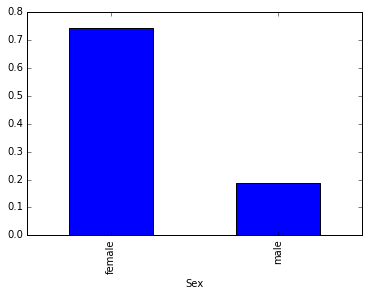

In [68]:
#create a pivot table (tableau croisé dynamique) to visualize the survival odds by gender
sex_pivot = train.pivot_table(index="Sex",values="Survived")
sex_pivot.plot.bar()

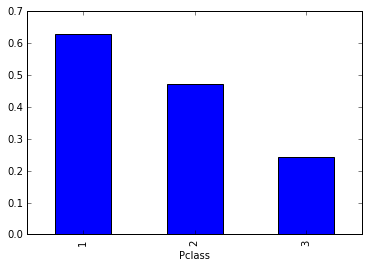

In [69]:
#create a pivot table (tableau croisé dynamique) to visualize the odds of survival by class
pclass_pivot = train.pivot_table(index = "Pclass", values = "Survived")
pclass_pivot.plot.bar()

#### The "age" column contains too many values ; we can group by age class

In [70]:
cut_points = [-1,0,5,12,18,35,60,100]
label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]

def process_age(df,cut_points,label_names):
    df["Age"] = df["Age"].fillna(-0.5)
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

In [71]:
train = process_age(train,cut_points,label_names)
holdout = process_age(holdout,cut_points,label_names)

### Visualising our new age features

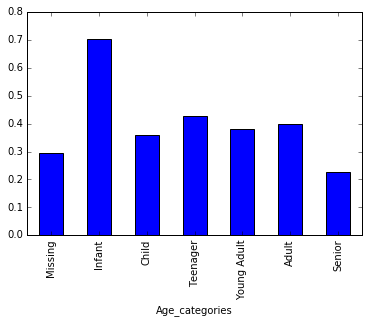

In [72]:
#plot the chances of survival by age_class
age_pivot = train.pivot_table(index = "Age_categories", values = "Survived")
age_pivot.plot.bar()

## Process the fare feature column. Adapt the process_age column seen earlier to the fare column

In [73]:
def process_fare(df, cut_points, label_names):
    df["Fare_categories"] = pd.cut(df["Fare"], cut_points, labels = label_names)
    return df

In [74]:
train = process_fare(train, [0,12,50,100,1000], ["0-12","12-50","50-100","100+"])

In [75]:
holdout = process_fare(holdout, [0,12,50,100,1000], ["0-12","12-50","50-100","100+"])

### Create a dummy coding function

In [76]:
def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [77]:
#create dummies for the Age_cat, Class, Sex, Embarked features & Fare

for col in ["Age_categories", "Pclass", "Sex", "Embarked", "Fare_categories"]:
    train = create_dummies(train, col)
    holdout = create_dummies(holdout, col)

### Data preprocessing : Fare and Embarked columns missing data

In [80]:
# the holdout DF has one missing value for the Fare feature. We can easliy replace it by the mean of that column.
# Same for the embarked column. We can easily replace it by the most common value, "S"

holdout["Fare"] = holdout["Fare"].fillna(train["Fare"].mean())
train["Embarked"] = train["Embarked"].fillna("S")
holdout["Embarked"] = holdout["Embarked"].fillna("S")

### Data preprocessing : Scaling down our values
#### Scale our numerical columns so that they have the same range and does not falsely influence our prediction.

In [81]:
from sklearn.preprocessing import minmax_scale

cols = ["SibSp", "Parch", "Fare"]
new_cols = ["SibSp_scaled", "Parch_scaled", "Fare_scaled"]

for col, new_col in zip(cols, new_cols):
    train[new_col] = minmax_scale(train[col])
    holdout[new_col] = minmax_scale(holdout[col])

C:\Users\Nahid\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, _DataConversionWarning)


In [82]:
# our SibSp and Parch got converted to floats when scaled, we should keep that in mind 

dtypes = train[cols + new_cols].dtypes

### Exploratory analysis : plotting correlations coefficients for each feature

#### Let's explore the relative importance of each feature thanks to regression coefficients. First, we define which columns we will explore

In [83]:
columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'SibSp_scaled', 'Parch_scaled', 'Fare_scaled']

columns_not_scaled = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'SibSp', 'Parch', 'Fare']

#### Then fit our model to the data and get the coefs for each feature

In [84]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

lr.fit(train[columns], train["Survived"])
coefficients = lr.coef_
feature_importance = pd.Series(coefficients[0], index = train[columns].columns)

lr.fit(train[columns_not_scaled], train["Survived"])
coefficients2 = lr.coef_
feature_importance_2 = pd.Series(coefficients2[0], index = train[columns_not_scaled].columns)

#### And plot it by descending order

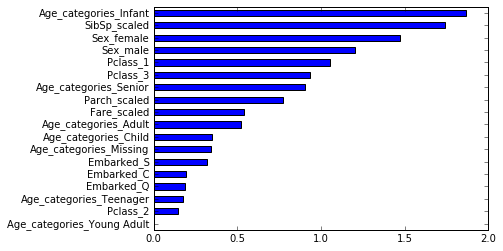

In [85]:
ordered_feature_importance = feature_importance.abs().sort_values()
#ordered_feature_importance_2 = feature_importance_2.abs().sort_values()
ordered_feature_importance.plot.barh(color = "blue")
#ordered_feature_importance_2.plot.barh(color = "red")
#plt.legend(['Scaling', 'No scaling'], loc = 4)

###### The 5th first features are the most important in the regression process

## Create a feature that gets the title of the person

In [86]:
def get_titles(train, test):
    titles_train = train["Name"].str.split(".", expand = True)
    titles_test = test["Name"].str.split(".", expand = True)
    titles_train = titles_train[0].str.split(",", expand = True)
    titles_test = titles_test[0].str.split(",", expand = True)
    titles_train = titles_train[1]
    titles_test = titles_test[1]
    train["titles"] = titles_train.astype("category")
    test["titles"] = titles_test.astype("category")
    #train = train.drop("Name", axis = 1)
    #test = test.drop("Name", axis = 1)
    return train, holdout

In [87]:
train, holdout = get_titles(train,holdout)

### Plot the chance of survival by title

In [88]:
import numpy as np

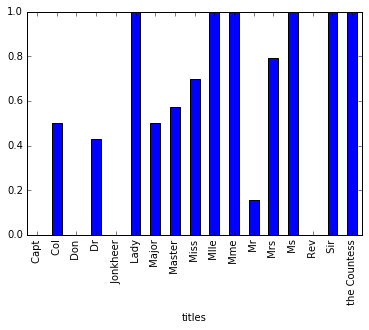

In [89]:
title_pivot = train.pivot_table(index = "titles", values = ["Survived"], aggfunc = [np.mean])
title_pivot.plot.bar(legend = False)

In [90]:
train = create_dummies(train,"titles")
holdout = create_dummies(holdout,"titles")

#### We can see that the feminine titles (Mlle, mme) have a one-on-one chance of survival based on the training set. On the other hand. Creating this feature has allowed us to have a more in depth understanding of the logic behind the lifeboat management.

## Now engineer the Cabin feature

In [91]:
train["Cabin"].head(10)

0     NaN
1     C85
2     NaN
3    C123
4     NaN
5     NaN
6     E46
7     NaN
8     NaN
9     NaN
Name: Cabin, dtype: object

In [92]:
print("number of null values :",train["Cabin"].isnull().sum())
print("number of non_null values :",train["Cabin"].notnull().sum())

number of null values : 687
number of non_null values : 204


### We have a lot of missing columns.

#### We can get the type of Cabin based on the first letter of the variables

In [93]:
train["Cabin"] = train["Cabin"].fillna("unknown")
holdout["Cabin"] = holdout["Cabin"].fillna("unknown")

In [94]:
cabins = train["Cabin"].tolist()
cabins_h = holdout["Cabin"].tolist()

#### Extract the first letter of each variable with the string method i[0:1]

In [95]:
cabins_type = []
for i in cabins:
    cabins_type.append(i[0:1])
    
cabins_type_holdout = []
for i in cabins_h:
    cabins_type_holdout.append(i[0:1])

In [96]:
train["Cabin"] = cabins_type
holdout["Cabin"] = cabins_type_holdout

In [97]:
train = create_dummies(train, "Cabin")
holdout = create_dummies(holdout, "Cabin")

In [98]:
print("We have now ",len(train.columns), "columns as predictors to fit")

We have now  63 columns as predictors to fit


### Now let's fit a logistic regression model. 
#### First define the columns we use as predictors

In [105]:
columns_cabins_titles = ['Age_categories_Missing', 'Age_categories_Infant',
'Age_categories_Child', 'Age_categories_Teenager',
'Age_categories_Young Adult', 'Age_categories_Adult',
'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
'Sex_female', 'SibSp_scaled', 'Parch_scaled',
'Fare_categories_0-12', 'Fare_categories_12-50',
'Fare_categories_50-100', 'Fare_categories_100+', 'titles_ Capt', 'titles_ Col', 'titles_ Don',
'titles_ Dr', 'titles_ Jonkheer', 'titles_ Lady', 'titles_ Major',
'titles_ Master', 'titles_ Miss', 'titles_ Mlle', 'titles_ Mme',
'titles_ Mr', 'titles_ Mrs', 'titles_ Ms', 'titles_ Rev', 'titles_ Sir',
'titles_ the Countess', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D',
'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_T', 'Cabin_u']

other_cols = ['Pclass_1', 'Pclass_2', 'Pclass_3']

#### Then define the actual model

In [106]:
from sklearn import model_selection

In [107]:
from sklearn.linear_model import LogisticRegression

In [108]:
logreg = LogisticRegression()
logreg.fit(train[columns_cabins_titles], train["Survived"])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [109]:
score = model_selection.cross_val_score(logreg, train[columns_cabins_titles], train["Survived"], cv = 10)

In [110]:
np.mean(score)

0.81939706049256622

### Let's plot the regression coefficients : regression coefficients are the importance of features in a model

In [111]:
logreg = LogisticRegression()


logreg.fit(train[columns_cabins_titles], train["Survived"])
feature_importance_2 = logreg.coef_

In [112]:
feature_importance_2 = pd.Series(feature_importance_2[0], index = train[columns_cabins_titles].columns)
ordered_feature_importance = feature_importance_2.abs().sort_values()

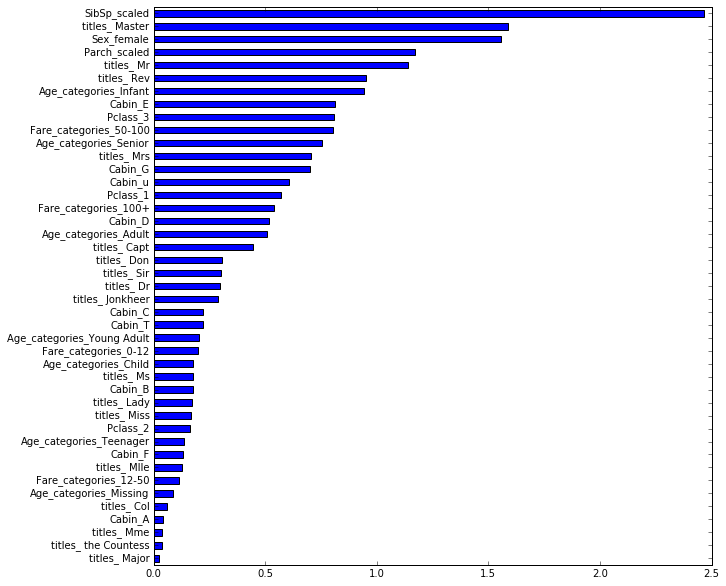

In [113]:
ordered_feature_importance.plot.barh(color = "blue", figsize = (10,10))

## Now let's look at possible colinearity between our features

Colinearity is when two or more feature provide the same information. It happens when you have : 
    - dummy variables
    - similar information (for example, Sex & Titles can provide the same information)
    
Colinearity leads to overfitting.

We can plot a Correlation heatmap for a dataset to see if there is collinearity.

In [114]:
columns = ['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Age_categories_Missing','Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', "titles_ Col", "titles_ Don", "titles_ Dr", "titles_ Master", "titles_ Miss", 
        "titles_ Mr", "titles_ Mrs", "titles_ Ms", "titles_ Rev"]

In [115]:
columns_cabins_titles = ['Age_categories_Missing', 'Age_categories_Infant',
'Age_categories_Child', 'Age_categories_Teenager',
'Age_categories_Young Adult', 'Age_categories_Adult',
'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
'Sex_female', 'SibSp_scaled', 'Parch_scaled',
'Fare_categories_0-12', 'Fare_categories_12-50',
'Fare_categories_50-100', 'Fare_categories_100+', 'titles_ Capt', 'titles_ Col', 'titles_ Don',
'titles_ Dr', 'titles_ Jonkheer', 'titles_ Lady', 'titles_ Major',
'titles_ Master', 'titles_ Miss', 'titles_ Mlle', 'titles_ Mme',
'titles_ Mr', 'titles_ Mrs', 'titles_ Ms', 'titles_ Rev', 'titles_ Sir',
'titles_ the Countess', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D',
'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_T']

In [116]:
import seaborn as sns

In [59]:
def plot_correlation_heatmap(df):
    corr = df.corr()
    
    sns.set(style="white")
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(520, 10, as_cmap=True)


    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()

In [60]:
corrs = train[columns_cabins_titles].corr()

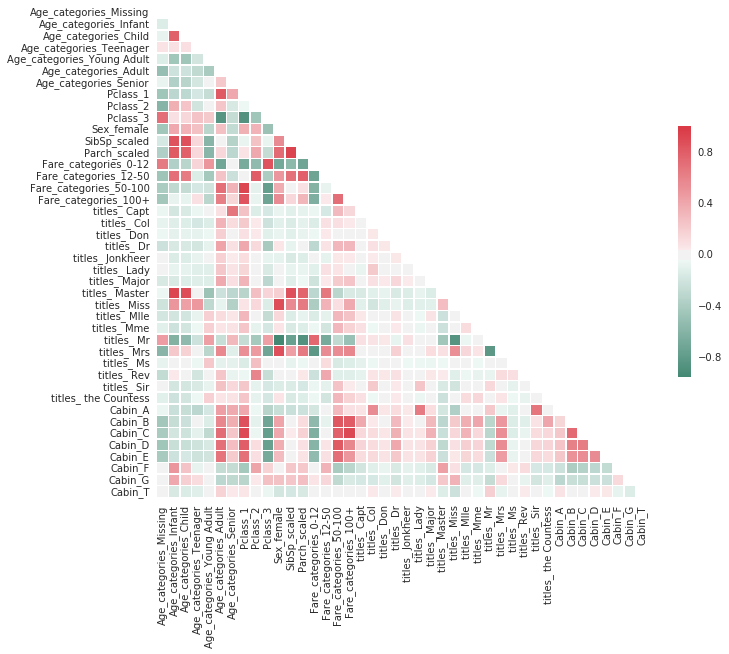

In [61]:
plot_correlation_heatmap(corrs.corr())

### Now that we have all our coefficients, we can manually select columns that have a too high collinearity with one another. We can also use scikit learn to do that job for us

In [62]:
from sklearn.feature_selection import RFECV
lr = LogisticRegression()
selector = RFECV(lr,cv=10)
selector.fit(train[columns_cabins_titles],train["Survived"])

RFECV(cv=10,
   estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
   n_jobs=1, scoring=None, step=1, verbose=0)

In [102]:
optimized_columns = train[columns_cabins_titles].columns[selector.support_]

In [69]:
print("We only have", len(optimized_columns), "columns left for our model. Let's test it")

We only have 20 columns left for our model. Let's test it


In [79]:
lr = LogisticRegression()
scores = model_selection.cross_val_score(lr, train[optimized_columns], train["Survived"], cv=10)
accuracy = scores.mean()

In [80]:
accuracy

0.82387924185676997

In [77]:
lr = LogisticRegression()
scores = model_selection.cross_val_score(lr, train[columns_cabins_titles], train["Survived"], cv=10)
scores.mean()

0.8160515265009648

In [124]:
#Before fitting our model to our real holdout dataset we should remove the "Captain" column since it does not exist in the 
#holdout.

optimized_columns = optimized_columns.drop("titles_ Capt")

In [106]:
lr = LogisticRegression()
lr.fit(train[optimized_columns],train["Survived"])
holdout_predictions = lr.predict(holdout[optimized_columns_holdout])

In [ ]:
holdout_ids = holdout["PassengerId"]
submission_df = {"PassengerId": holdout_ids,
                 "Survived": holdout_predictions}
submission = pd.DataFrame(submission_df)

submission.to_csv("submission_2.csv",index=False)